In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import re
import math
from collections import Counter
import missingno as msno
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.metrics import  roc_curve, f1_score, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from xgboost import XGBClassifier

from ipywidgets import interactive, FloatSlider
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Useful Functions

In [2]:
# This function turns all letters to lower case and convert features containing 'sk_id_' to string format
def clean_header(df):
    id_columns = re.compile('sk_id_')
    df.columns = map(str.lower, df.columns)
    for i in df.columns:
        if id_columns.search(i):
            df[i] = df[i].astype(str)
    return df

In [3]:
# This function returns the percentage of NaN in each column
def nan_percentage(df):
    return round(((df.isnull().sum(axis = 0)) * 100 / len(df)),2).sort_values(ascending=False)

In [4]:
# This function shows the unique values of each categorical column
def categorical_unique(df):
    for i in df.select_dtypes(['object']).columns:
        print(i, ':', df.loc[:,i].unique())
        print(df.loc[:,i].dtypes)
        print('')

In [6]:
# This function shows the unique values of each categorical column
def cat_default_rate(df, col_size=2):
    col = col_size
    plot_num = df.select_dtypes(['object']).columns.size - 2
    row = math.ceil(plot_num / col)
    fig, axs = plt.subplots(row,col, figsize=(8*col,8*row))
    for i, col_name in enumerate(df.select_dtypes(['object']).columns[2:]):
        sns.barplot(y=col_name, x='target', data=pd.DataFrame(df.groupby(col_name).target.mean())
                    .sort_values(by='target', ascending=False).reset_index(),
                    color='maroon', ax=axs[math.floor(i/col),i%col])
    fig.tight_layout()

In [7]:
# This function shows distribution plots of all numerical features
def multi_numerical_distplot(df, col_size=2):
    col = col_size
    plot_num = df.select_dtypes(['int64','float64']).columns.size
    row = math.ceil(plot_num / col)
    fig, axs = plt.subplots(row,col, figsize=(8*col,5*row))
    for i, col_name in enumerate(df.select_dtypes(['int64','float64']).columns):
        nonan_values = df[col_name].dropna()
        sns.distplot(nonan_values, color='green', kde=0 ,bins=30 ,ax=axs[math.floor(i/col),i%col]);
    fig.tight_layout()

In [8]:
# This function shows the performance metrics from model prediction
def show_model_metrics(clf, y_test, X_test, model_type):
    y_predict = clf.predict(X_test)
    y_predict_proba = clf.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test,y_predict)
    ll = log_loss(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    roc_auc = roc_auc_score(y_test,y_predict_proba)
    print('<',model_type,'Scores>')
    print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
          .format(accuracy, ll, precision, f1, recall, roc_auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    plt.plot(fpr, tpr,lw=2,c='red')
    plt.plot([0,1],[0,1],c='blue',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - '+model_type)

In [9]:
# This function display the interactive confusion matrix
def interactive_confusion_matrix(model, y_test, X_test, model_type, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Normal', 'Default'],
           yticklabels=['Normal', 'Default'])
    plt.title('Confusion Matrix: '+model_type);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [10]:
# This function reports the feature importance in dataframe format 
def rf_feature_importance_report(rf_model, features_list):
    report = pd.DataFrame(zip(features_list, rf_model.feature_importances_)).sort_values(by=1, ascending=False)
    report = report.rename(columns={0:'features',1:'feature_importance'}).reset_index().drop(columns='index')
    return report

In [11]:
# This function reports the result of cross validation
def report_cv_results(cv, result_type='all'):
    print('Cross Validation Averages:')
    if result_type=='test':
        for i in [j for j in cv.keys() if re.search('test',j)]:
            print(i, ':', cv[i].mean())
    elif result_type=='train':
        for i in [j for j in cv.keys() if re.search('train',j)]:
            print(i, ':', cv[i].mean())
    else:
        for i in cv.keys():
            print(i, ':', cv[i].mean())

### Data Import

In [12]:
# Connect to my AWS server and 'project5' database
params = {
    'host': '3.130.17.136',
    'user': 'ubuntu',
    'port': 5432
}
connection = pg.connect(**params, dbname='project5')
cursor = connection.cursor()

In [13]:
# Query 'application_train' data using Postgresql
application_train_df = pd.read_sql("""

SELECT *
FROM application_train

""", connection)

In [15]:
# Query 'prev_application' data using Postgresql
prev_application_df = pd.read_sql("""

SELECT *
FROM previous_application

""", connection)

### Data Preprocessing

In [16]:
# Use clean_header function to 'application_train_df' and 'prev_application_df'
clean_header(application_train_df)
clean_header(prev_application_df);

In [17]:
prev_application_df.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,None,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,None,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,None,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
prev_application_df.shape

(1670214, 37)

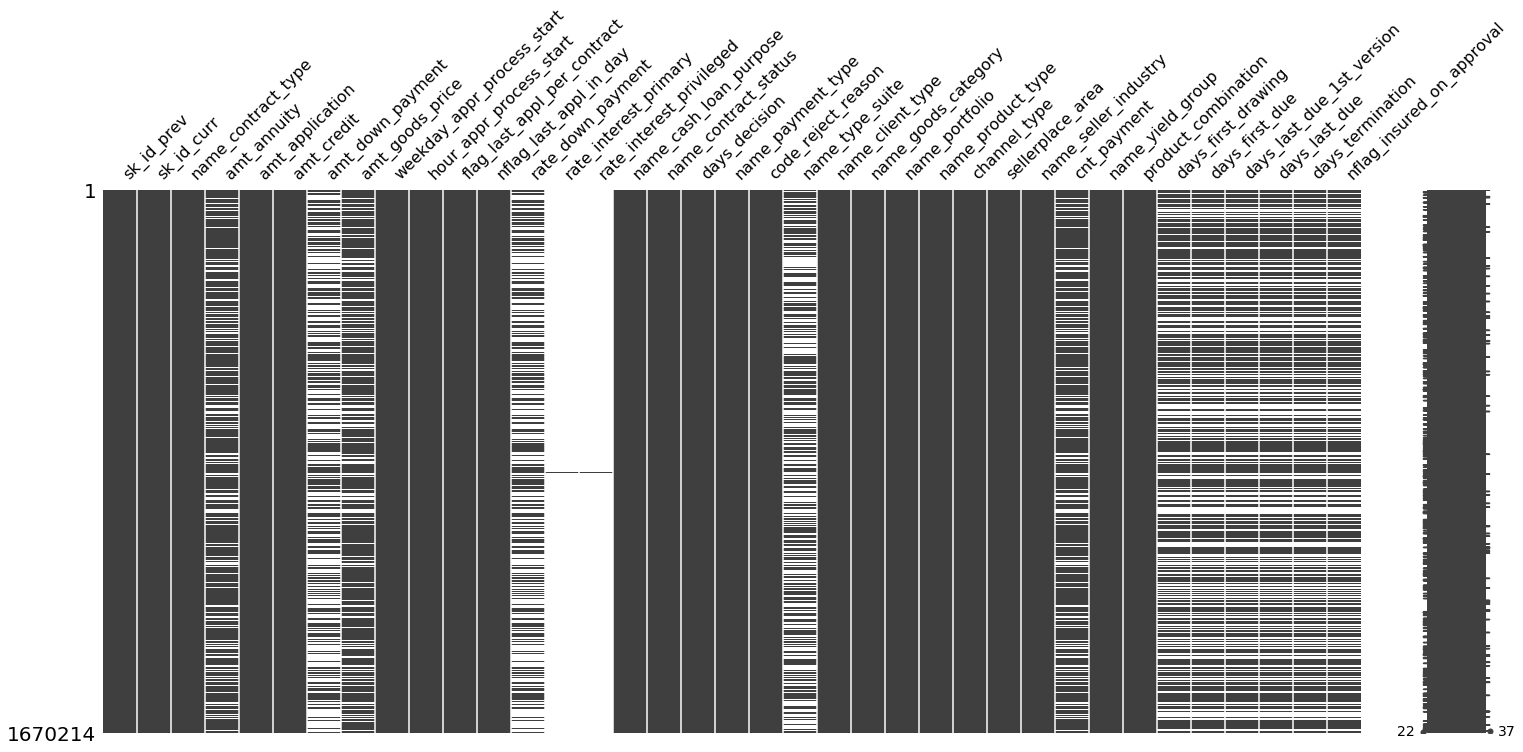

In [19]:
# Use missingno tool to get a big picture of missing values in each column
msno.matrix(prev_application_df);

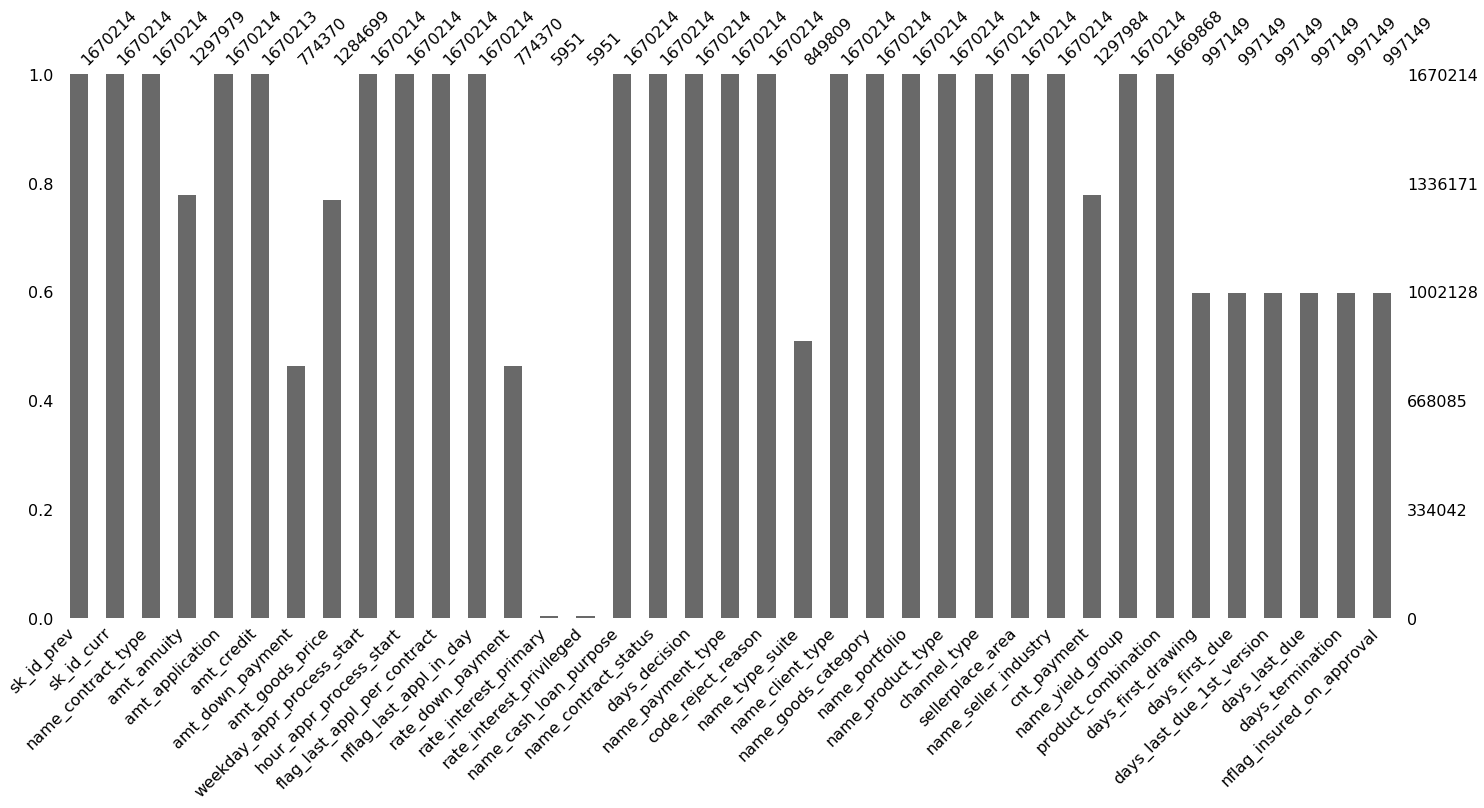

In [20]:
# Use missingno tool to show the percentage of non-NaN values in each column
msno.bar(prev_application_df);

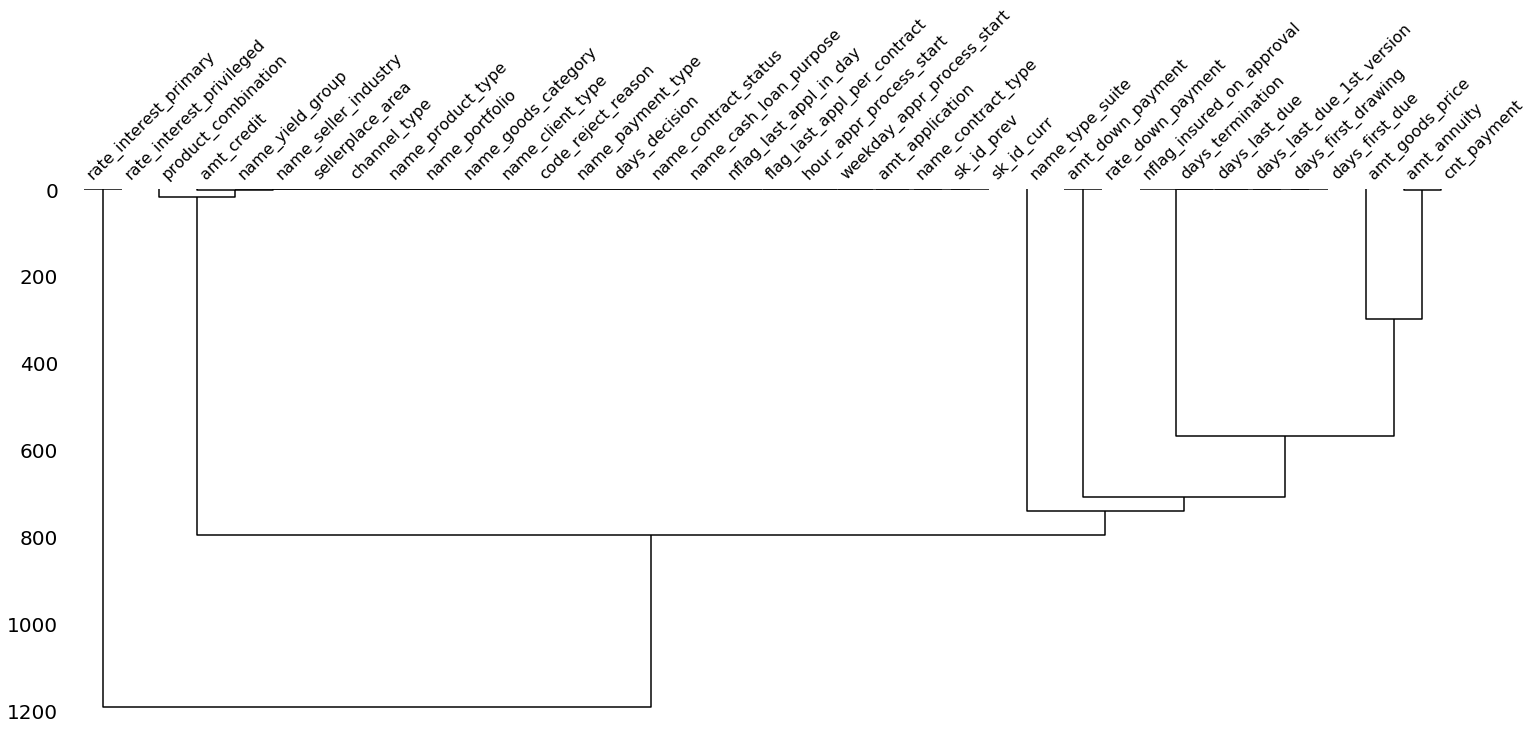

In [21]:
# This shows the hierarchical tree representing groupings of columns that have strong nullity correlations
msno.dendrogram(prev_application_df);

In [22]:
# Display unique values of categorical features
categorical_unique(prev_application_df)

sk_id_prev : ['2030495' '2802425' '2523466' ... '2659632' '2785582' '2418762']
object

sk_id_curr : ['271877' '108129' '122040' ... '253940' '353284' '191629']
object

name_contract_type : ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
object

weekday_appr_process_start : ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
object

flag_last_appl_per_contract : ['Y' 'N']
object

name_cash_loan_purpose : ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']
object

name_contract_status : ['Approved' 'Refused' 'Canceled' 'Unused offer']
object

name_

In [23]:
# Adding loan status from 'application_train_df' to 'prev_application_df'
prev_application_df = pd.merge(application_train_df[['sk_id_curr','target']], prev_application_df, on='sk_id_curr')

# Select features to remain in the dataframe
prev_application_df = prev_application_df[['sk_id_curr', 'sk_id_prev', 'target', 'name_contract_type', 'amt_annuity',
                                           'amt_application', 'amt_credit', 'amt_down_payment', 'amt_goods_price',
                                           'weekday_appr_process_start', 'hour_appr_process_start',
                                           'flag_last_appl_per_contract', 'nflag_last_appl_in_day',
                                           'rate_down_payment', 'rate_interest_primary', 'rate_interest_privileged',
                                           'name_cash_loan_purpose', 'name_contract_status', 'days_decision',
                                           'name_payment_type', 'code_reject_reason', 'name_type_suite',
                                           'name_client_type', 'name_goods_category', 'name_portfolio',
                                           'name_product_type', 'channel_type', 'sellerplace_area',
                                           'name_seller_industry', 'cnt_payment', 'name_yield_group',
                                           'product_combination', 'days_first_drawing', 'days_first_due',
                                           'days_last_due_1st_version', 'days_last_due', 'days_termination',
                                           'nflag_insured_on_approval']]

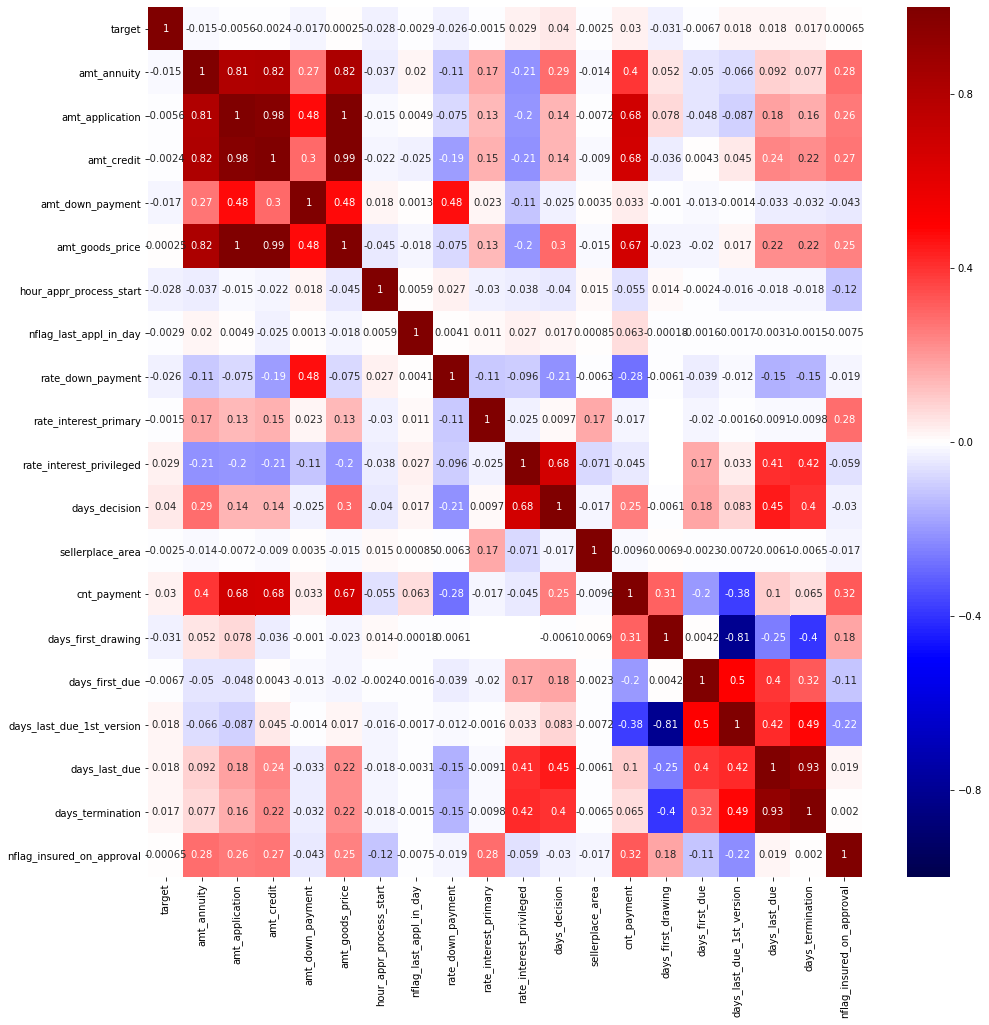

In [24]:
# Plot the correlation map of all numerical features
plt.figure(figsize=(16, 16))
sns.heatmap(prev_application_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### EDA

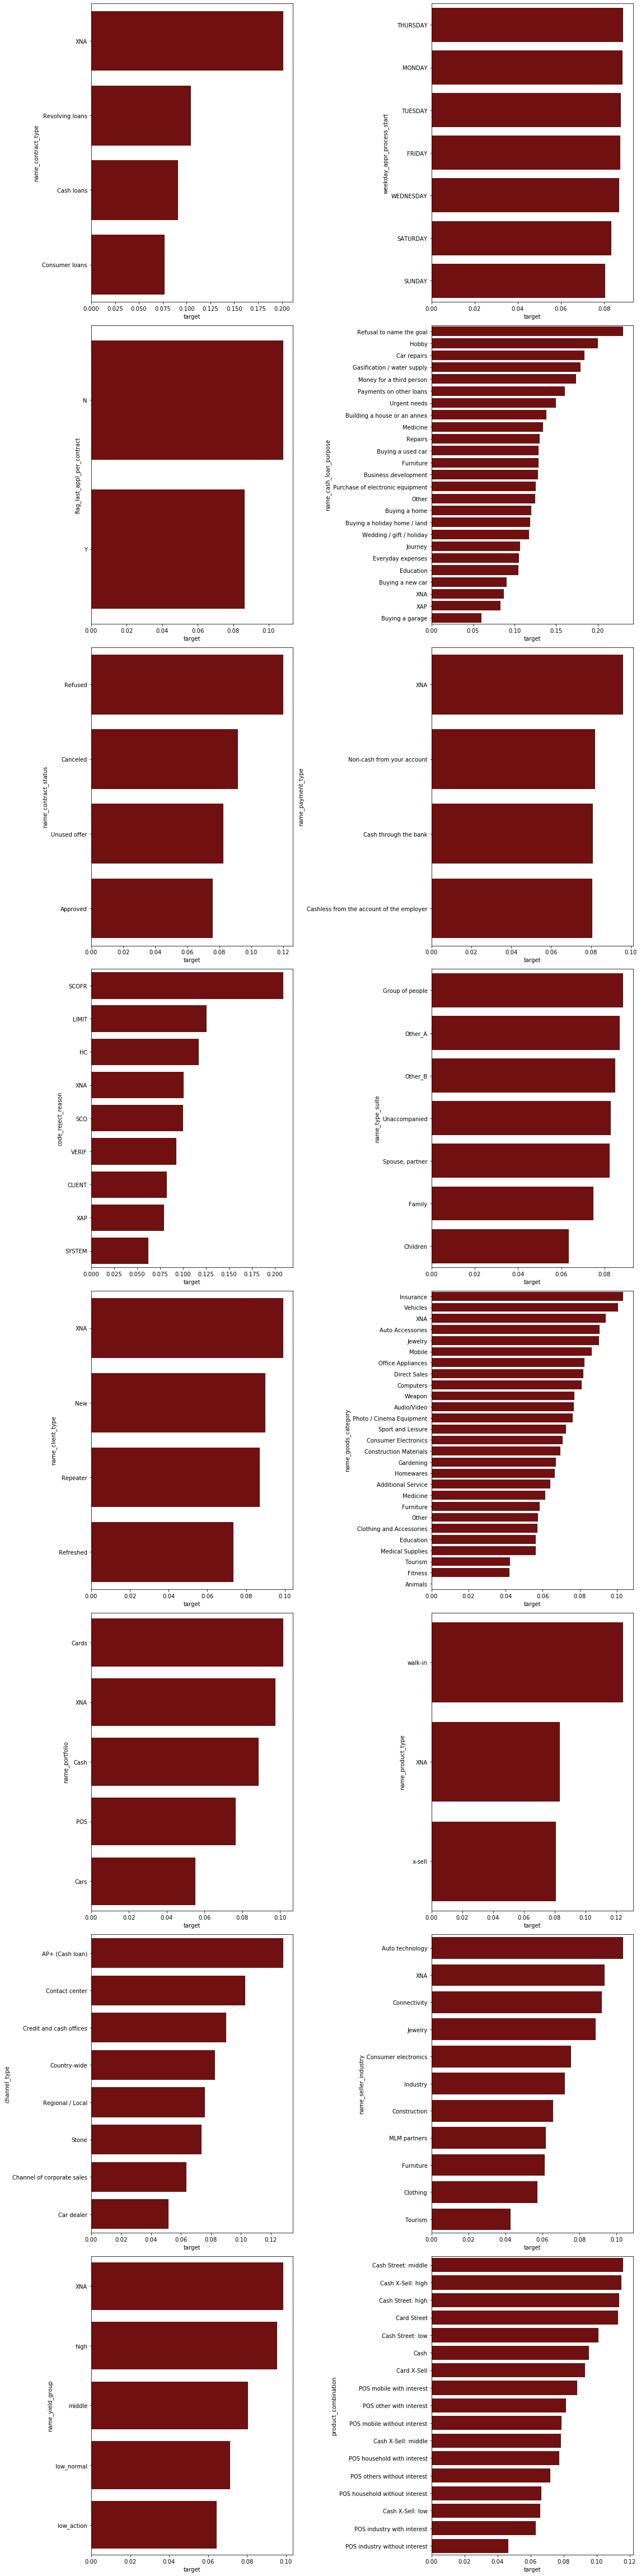

In [25]:
# Apply the function cat_default_rate to previous application dataframe to find out the default rate of 
# categorical features
cat_default_rate(prev_application_df)

### Continue with Data Preprocessing

In [26]:
# Drop features which do not show strong correlation to loan status
prev_application_df = prev_application_df.drop(
    columns=['name_portfolio','rate_interest_primary','rate_interest_privileged','weekday_appr_process_start',
             'hour_appr_process_start','days_first_drawing', 'days_first_due','days_last_due_1st_version', 
             'days_last_due', 'days_termination','weekday_appr_process_start'])

In [27]:
prev_application_df.head()

,sk_id_curr,sk_id_prev,target,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,nflag_insured_on_approval
0,228356,1978811,0,Consumer loans,3264.795,31756.5,27481.5,6750.0,31756.5,Y,1,0.214754,XAP,Approved,-2211,Cash through the bank,XAP,Unaccompanied,Repeater,Mobile,XNA,Country-wide,23,Connectivity,12.0,high,POS mobile with interest,0.0
1,228356,2293478,0,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,Y,1,NaN,XAP,Approved,-412,XNA,XAP,Unaccompanied,Refreshed,XNA,walk-in,Country-wide,150,Consumer electronics,0.0,XNA,Card Street,0.0
2,228356,2189717,0,Consumer loans,5555.790,42750.0,41647.5,4275.0,42750.0,Y,1,0.101385,XAP,Approved,-2661,Cash through the bank,XAP,"Spouse, partner",Refreshed,Mobile,XNA,Stone,38,Consumer electronics,10.0,high,POS household with interest,1.0
3,228356,1570960,0,Consumer loans,3715.830,19305.0,20452.5,0.0,19305.0,Y,1,0.000000,XAP,Approved,-412,Cash through the bank,XAP,Unaccompanied,Refreshed,Construction Materials,XNA,Stone,167,Industry,6.0,middle,POS industry with interest,1.0
4,228357,2817709,0,Consumer loans,4599.045,85122.0,101974.5,0.0,85122.0,Y,1,0.000000,XAP,Approved,-1159,Cash through the bank,XAP,Family,New,Consumer Electronics,XNA,Country-wide,4232,Consumer electronics,24.0,low_action,POS household without interest,0.0


In [28]:
# Fill NaN values of numerical features with zero and categorical features with 'XNA'
for col in prev_application_df:
    #get dtype for column### Use RF to pick important features
    dt = prev_application_df[col].dtype 
    #check if it is a number
    if dt == int or dt == float:
        prev_application_df[col] = prev_application_df[col].fillna(0)
    else:
        prev_application_df[col] = prev_application_df[col].fillna('XNA')

In [29]:
prev_application_df.head(1)

,sk_id_curr,sk_id_prev,target,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,nflag_insured_on_approval
0,228356,1978811,0,Consumer loans,3264.795,31756.5,27481.5,6750.0,31756.5,Y,1,0.214754,XAP,Approved,-2211,Cash through the bank,XAP,Unaccompanied,Repeater,Mobile,XNA,Country-wide,23,Connectivity,12.0,high,POS mobile with interest,0.0


In [30]:
# Create a list of all categorical features
dummy_list = [i for i in prev_application_df if prev_application_df[i].dtypes=='object'][2:]

In [31]:
# Apply one hot encoding to categorical features
prev_application_df = pd.get_dummies(prev_application_df, columns=dummy_list, drop_first=True)

In [32]:
# Create aggregation dictionary that will be use with dataframe that groups 'sk_id_curr' together
agg_dict = {}
for i in prev_application_df:
    if (prev_application_df[i].dtypes=='float64') or (prev_application_df[i].dtypes=='int64'):
        agg_dict[i] = 'mean'
    elif prev_application_df[i].dtypes=='uint8':
        agg_dict[i] = 'sum'
agg_dict['sk_id_prev'] = 'count'

In [33]:
# Group previous application dataframe by 'sk_id_curr' and apply custom aggregation
prev_application_df = prev_application_df.groupby('sk_id_curr').agg(agg_dict)

### Use RF to pick important features

In [34]:
# Splitting data to independent and dependent variables
y = prev_application_df.iloc[:,0]
X = prev_application_df.drop(columns=['target'])

In [35]:
prev_application_df.head()

,target,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,nflag_last_appl_in_day,rate_down_payment,days_decision,sellerplace_area,cnt_payment,nflag_insured_on_approval,name_contract_type_Consumer loans,name_contract_type_Revolving loans,name_contract_type_XNA,flag_last_appl_per_contract_Y,name_cash_loan_purpose_Business development,name_cash_loan_purpose_Buying a garage,name_cash_loan_purpose_Buying a holiday home / land,name_cash_loan_purpose_Buying a home,name_cash_loan_purpose_Buying a new car,name_cash_loan_purpose_Buying a used car,name_cash_loan_purpose_Car repairs,name_cash_loan_purpose_Education,name_cash_loan_purpose_Everyday expenses,name_cash_loan_purpose_Furniture,name_cash_loan_purpose_Gasification / water supply,name_cash_loan_purpose_Hobby,name_cash_loan_purpose_Journey,name_cash_loan_purpose_Medicine,name_cash_loan_purpose_Money for a third person,name_cash_loan_purpose_Other,name_cash_loan_purpose_Payments on other loans,name_cash_loan_purpose_Purchase of electronic equipment,name_cash_loan_purpose_Refusal to name the goal,name_cash_loan_purpose_Repairs,name_cash_loan_purpose_Urgent needs,name_cash_loan_purpose_Wedding / gift / holiday,name_cash_loan_purpose_XAP,name_cash_loan_purpose_XNA,name_contract_status_Canceled,name_contract_status_Refused,name_contract_status_Unused offer,name_payment_type_Cashless from the account of the employer,name_payment_type_Non-cash from your account,name_payment_type_XNA,code_reject_reason_HC,code_reject_reason_LIMIT,code_reject_reason_SCO,code_reject_reason_SCOFR,code_reject_reason_SYSTEM,code_reject_reason_VERIF,code_reject_reason_XAP,code_reject_reason_XNA,name_type_suite_Family,name_type_suite_Group of people,name_type_suite_Other_A,name_type_suite_Other_B,"name_type_suite_Spouse, partner",name_type_suite_Unaccompanied,name_type_suite_XNA,name_client_type_Refreshed,name_client_type_Repeater,name_client_type_XNA,name_goods_category_Animals,name_goods_category_Audio/Video,name_goods_category_Auto Accessories,name_goods_category_Clothing and Accessories,name_goods_category_Computers,name_goods_category_Construction Materials,name_goods_category_Consumer Electronics,name_goods_category_Direct Sales,name_goods_category_Education,name_goods_category_Fitness,name_goods_category_Furniture,name_goods_category_Gardening,name_goods_category_Homewares,name_goods_category_Insurance,name_goods_category_Jewelry,name_goods_category_Medical Supplies,name_goods_category_Medicine,name_goods_category_Mobile,name_goods_category_Office Appliances,name_goods_category_Other,name_goods_category_Photo / Cinema Equipment,name_goods_category_Sport and Leisure,name_goods_category_Tourism,name_goods_category_Vehicles,name_goods_category_Weapon,name_goods_category_XNA,name_product_type_walk-in,name_product_type_x-sell,channel_type_Car dealer,channel_type_Channel of corporate sales,channel_type_Contact center,channel_type_Country-wide,channel_type_Credit and cash offices,channel_type_Regional / Local,channel_type_Stone,name_seller_industry_Clothing,name_seller_industry_Connectivity,name_seller_industry_Construction,name_seller_industry_Consumer electronics,name_seller_industry_Furniture,name_seller_industry_Industry,name_seller_industry_Jewelry,name_seller_industry_MLM partners,name_seller_industry_Tourism,name_seller_industry_XNA,name_yield_group_high,name_yield_group_low_action,name_yield_group_low_normal,name_yield_group_middle,product_combination_Card X-Sell,product_combination_Cash,product_combination_Cash Street: high,product_combination_Cash Street: low,product_combination_Cash Street: middle,product_combination_Cash X-Sell: high,product_combination_Cash X-Sell: low,product_combination_Cash X-Sell: middle,product_combination_POS household with interest,product_combination_POS household without interest,product_combination_POS industry with interest,product_combination_POS industry without interest,product_combination_POS mobile with interest,product_combination_POS mobile wit

In [36]:
print('Base: Data classes before splitting: ',sorted(Counter(y).items()))

Base: Data classes before splitting:  [(0, 267212), (1, 23845)]


In [37]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=88)
print('Data classes after splitting')
print('Base Train data: ',sorted(Counter(y_train).items()))
print('Base Test data: ',sorted(Counter(y_test).items()))

Data classes after splitting
Base Train data:  [(0, 213769), (1, 19076)]
Base Test data:  [(0, 53443), (1, 4769)]


In [38]:
# Scale data using StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [39]:
# Apply ADAYSN due to imbalanced classes
adaysn = ADASYN(random_state=77)
X_train_scaled, y_train = adaysn.fit_resample(X_train_scaled, y_train)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

Train data:  [(0, 213769), (1, 209748)]
Test data:  [(0, 53443), (1, 4769)]


In [40]:
# Fit training data to Random Forest
rf = RandomForestClassifier(bootstrap=True, max_depth= 3, n_estimators=150, random_state=77)
rf.fit(X_train_scaled , y_train);

< Random Forest Scores>
Accuracy: 0.7362227719370577
Log Loss: 9.110711595441753
Precision: 0.12209053262887334
F1: 0.1821571238348868
Recall :0.35856573705179284
ROC AUC: 0.6052316005890179


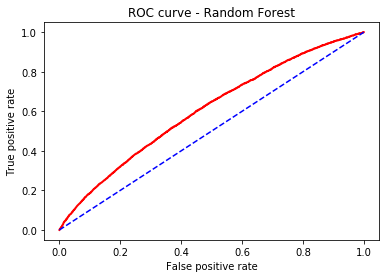

In [41]:
show_model_metrics(rf, y_test, X_test_scaled, 'Random Forest')

In [42]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(rf, y_test, X_test_scaled , 'Random Forest',
                                                           threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [43]:
# Get the important features
feature_importance_df = rf_feature_importance_report(rf, X_train.columns)
feature_importance_df 

,features,feature_importance
0,name_yield_group_low_normal,0.114764
1,name_type_suite_Family,0.085479
2,name_client_type_Refreshed,0.074222
3,product_combination_Cash X-Sell: low,0.055900
4,name_contract_status_Refused,0.055516
5,channel_type_Stone,0.053409
6,name_yield_group_high,0.050024
7,code_reject_reason_HC,0.042415
8,name_product_type_walk-in,0.036514
9,name_contract_type_Consumer loans,0.027684


In [44]:
# Create list of important features
rf_important_features_list = list(feature_importance_df[feature_importance_df['feature_importance']!=0]['features'])

In [45]:
prev_application_df[rf_important_features_list].head()

,name_yield_group_low_normal,name_type_suite_Family,name_client_type_Refreshed,product_combination_Cash X-Sell: low,name_contract_status_Refused,channel_type_Stone,name_yield_group_high,code_reject_reason_HC,name_product_type_walk-in,name_contract_type_Consumer loans,product_combination_Cash,name_payment_type_XNA,name_yield_group_low_action,name_type_suite_Unaccompanied,name_seller_industry_Consumer electronics,code_reject_reason_XAP,channel_type_Regional / Local,name_type_suite_XNA,name_yield_group_middle,name_contract_type_Revolving loans,name_goods_category_Consumer Electronics,sk_id_prev,name_contract_status_Canceled,product_combination_POS household without interest,name_seller_industry_Connectivity,product_combination_Cash X-Sell: middle,product_combination_Cash X-Sell: high,channel_type_Country-wide,product_combination_POS industry with interest,product_combination_POS household with interest,name_cash_loan_purpose_XAP,flag_last_appl_per_contract_Y,name_product_type_x-sell,name_client_type_Repeater,name_goods_category_Mobile,channel_type_Credit and cash offices,days_decision,product_combination_Card X-Sell,"name_type_suite_Spouse, partner",channel_type_Contact center,name_goods_category_XNA,product_combination_POS mobile with interest,name_seller_industry_XNA,amt_down_payment,nflag_insured_on_approval,code_reject_reason_LIMIT,name_goods_category_Audio/Video,name_cash_loan_purpose_XNA,sellerplace_area,code_reject_reason_SCOFR,amt_annuity,product_combination_Cash Street: high,amt_application,code_reject_reason_SCO,product_combination_Cash Street: low,name_goods_category_Photo / Cinema Equipment,name_goods_category_Computers,name_seller_industry_Furniture,amt_goods_price,cnt_payment,name_goods_category_Furniture,product_combination_POS industry without interest,name_goods_category_Construction Materials
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-606.000000,0,0,0,0,0,0,0.00,0.000000,0,0,0,500.000000,0,9251.775,0,179055.00,0,0,0,0,0,179055.00,24.000000,0,0,0
100003,1,2,2,1,0,1,0,0,0,2,0,1,0,1,1,3,0,0,2,0,1,3,0,0,0,0,0,1,1,1,2,3,1,1,0,1,-1305.000000,0,0,0,1,0,1,2295.00,0.666667,0,0,1,533.000000,0,56553.990,0,435436.50,0,0,0,0,1,435436.50,10.000000,1,0,0
100004,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,-815.000000,0,0,0,0,0,0,4860.00,0.000000,0,0,0,30.000000,0,5357.250,0,24282.00,0,0,0,0,0,24282.00,4.000000,0,0,0
100006,2,1,0,2,1,1,2,0,0,2,2,5,0,3,1,8,0,5,1,2,0,9,3,0,0,0,1,1,1,1,4,9,4,8,0,7,-272.444444,1,0,0,7,0,7,7742.26,0.000000,1,1,5,894.222222,0,15767.450,0,272203.26,0,0,0,0,0,272203.26,15.333333,0,0,1
100007,0,2,0,0,0,0,3,0,1,2,0,1,0,2,3,6,1,2,3,0,0,6,0,0,1,3,0,3,0,1,2,6,3,5,0,1,-1222.833333,0,0,0,4,1,2,1130.25,0.500000,0,2,4,409.166667,0,12278.805,1,150530.25,0,0,0,0,0,150530.25,20.666667,0,0,0


In [46]:
# Create a previous application dataset which contains important features to be exported and used with main dataset
prev_application_transfer_df = prev_application_df[rf_important_features_list]
prev_application_transfer_df.columns = ['prev_'+i for i in prev_application_transfer_df.columns]
prev_application_transfer_df.head()

,prev_name_yield_group_low_normal,prev_name_type_suite_Family,prev_name_client_type_Refreshed,prev_product_combination_Cash X-Sell: low,prev_name_contract_status_Refused,prev_channel_type_Stone,prev_name_yield_group_high,prev_code_reject_reason_HC,prev_name_product_type_walk-in,prev_name_contract_type_Consumer loans,prev_product_combination_Cash,prev_name_payment_type_XNA,prev_name_yield_group_low_action,prev_name_type_suite_Unaccompanied,prev_name_seller_industry_Consumer electronics,prev_code_reject_reason_XAP,prev_channel_type_Regional / Local,prev_name_type_suite_XNA,prev_name_yield_group_middle,prev_name_contract_type_Revolving loans,prev_name_goods_category_Consumer Electronics,prev_sk_id_prev,prev_name_contract_status_Canceled,prev_product_combination_POS household without interest,prev_name_seller_industry_Connectivity,prev_product_combination_Cash X-Sell: middle,prev_product_combination_Cash X-Sell: high,prev_channel_type_Country-wide,prev_product_combination_POS industry with interest,prev_product_combination_POS household with interest,prev_name_cash_loan_purpose_XAP,prev_flag_last_appl_per_contract_Y,prev_name_product_type_x-sell,prev_name_client_type_Repeater,prev_name_goods_category_Mobile,prev_channel_type_Credit and cash offices,prev_days_decision,prev_product_combination_Card X-Sell,"prev_name_type_suite_Spouse, partner",prev_channel_type_Contact center,prev_name_goods_category_XNA,prev_product_combination_POS mobile with interest,prev_name_seller_industry_XNA,prev_amt_down_payment,prev_nflag_insured_on_approval,prev_code_reject_reason_LIMIT,prev_name_goods_category_Audio/Video,prev_name_cash_loan_purpose_XNA,prev_sellerplace_area,prev_code_reject_reason_SCOFR,prev_amt_annuity,prev_product_combination_Cash Street: high,prev_amt_application,prev_code_reject_reason_SCO,prev_product_combination_Cash Street: low,prev_name_goods_category_Photo / Cinema Equipment,prev_name_goods_category_Computers,prev_name_seller_industry_Furniture,prev_amt_goods_price,prev_cnt_payment,prev_name_goods_category_Furniture,prev_product_combination_POS industry without interest,prev_name_goods_category_Construction Materials
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-606.000000,0,0,0,0,0,0,0.00,0.000000,0,0,0,500.000000,0,9251.775,0,179055.00,0,0,0,0,0,179055.00,24.000000,0,0,0
100003,1,2,2,1,0,1,0,0,0,2,0,1,0,1,1,3,0,0,2,0,1,3,0,0,0,0,0,1,1,1,2,3,1,1,0,1,-1305.000000,0,0,0,1,0,1,2295.00,0.666667,0,0,1,533.000000,0,56553.990,0,435436.50,0,0,0,0,1,435436.50,10.000000,1,0,0
100004,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,-815.000000,0,0,0,0,0,0,4860.00,0.000000,0,0,0,30.000000,0,5357.250,0,24282.00,0,0,0,0,0,24282.00,4.000000,0,0,0
100006,2,1,0,2,1,1,2,0,0,2,2,5,0,3,1,8,0,5,1,2,0,9,3,0,0,0,1,1,1,1,4,9,4,8,0,7,-272.444444,1,0,0,7,0,7,7742.26,0.000000,1,1,5,894.222222,0,15767.450,0,272203.26,0,0,0,0,0,272203.26,15.333333,0,0,1
100007,0,2,0,0,0,0,3,0,1,2,0,1,0,2,3,6,1,2,3,0,0,6,0,0,1,3,0,3,0,1,2,6,3,5,0,1,-1222.833333,0,0,0,4,1,2,1130.25,0.500000,0,2,4,409.166667,0,12278.805,1,150530.25,0,0,0,0,0,150530.25,20.666667,0,0,0


In [55]:
# Save previous application dataset with important features as pickle file
with open('prev_application_transfer.pickle', 'wb') as to_write:
    pickle.dump(prev_application_transfer_df, to_write)